In [ ]:
import sys

sys.path.append("../mlp_to_qbaf/")
import pandas as pd
from graphviz import Digraph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import torch

from mlp_to_qbaf import MLPToQBAF

iris = pd.read_csv("../data/iris.data", names=["sepal_length", "sepal_width", "petal_length", "petal_width", "class"])
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [101]:
label_encoder = LabelEncoder()

iris["class"] = label_encoder.fit_transform(iris["class"])

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [102]:
X = iris.drop(columns="class").to_numpy()
y = iris["class"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=2024,
)

In [103]:
class IrisClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(4, 2)
        self.fc2 = torch.nn.Linear(2, 3)
        self.layers = [self.fc1, self.fc2]

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            return torch.argmax(self.forward(x), dim=1)

    def accuracy(self, x, y):
        return torch.sum(self.predict(x) == y).item() / len(y)

In [104]:
iters = 10000
model = IrisClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(iters):
    criterion = torch.nn.CrossEntropyLoss()

    optimizer.zero_grad()
    y_pred = model.forward(torch.tensor(X_train, dtype=torch.float32))
    loss = criterion(y_pred, torch.tensor(y_train, dtype=torch.long))
    loss.backward()
    optimizer.step()


In [105]:
accuracy = model.accuracy(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.33%


In [106]:
weights = []
biases = []

for layer in model.layers:
    weights.append(layer.weight.detach().numpy().T)
    biases.append(layer.bias.detach().numpy().T)

In [107]:
weights[0]

array([[ -0.04431295,   4.579615  ],
       [  2.9451032 ,  12.2896    ],
       [ -3.1517942 , -11.180107  ],
       [ -2.7291183 , -11.073195  ]], dtype=float32)

In [108]:
converter = MLPToQBAF([4, 2, 3], weights, biases, "logistic", [0.5] * 4)

qbaf = converter.get_qbaf()

In [109]:
for arg in qbaf.arguments.values():
    print((arg.name, arg.strength))

('Layer 0 Neuron 1', 0.5)
('Layer 1 Neuron 1', 0.6843664165468443)
('Layer 1 Neuron 2', 0.9972889417769651)
('Layer 0 Neuron 2', 0.5)
('Layer 0 Neuron 3', 0.5)
('Layer 0 Neuron 4', 0.5)
('Layer 2 Neuron 1', 0.9932588492432567)
('Layer 2 Neuron 2', 0.7777989279734304)
('Layer 2 Neuron 3', 0.014115756504303807)


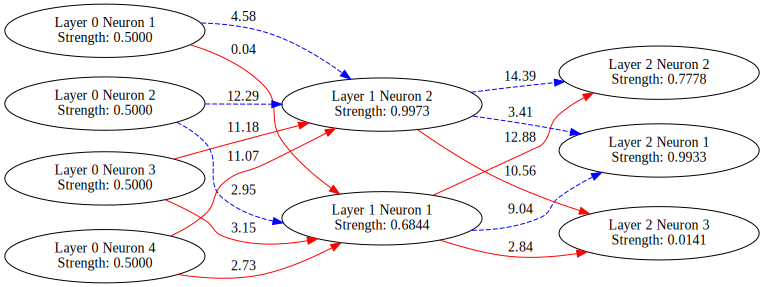

In [113]:
# Create a directed graph using Graphviz
QBAF_graph = Digraph()
QBAF_graph.attr(rankdir="LR")

# Sort arguments by layer and neuron

for arg in qbaf.arguments.values():
    QBAF_graph.node(arg.name, label=f"{arg.name}\nStrength: {arg.strength:.4f}")

for attack in qbaf.attacks:
    attack_weight = round(attack.attacked.attackers[attack.attacker].astype(float), 2)
    QBAF_graph.edge(attack.attacker.name,
                    attack.attacked.name,
                    style="solid",
                    color="red",
                    label=f"{attack_weight}",
                    )

for support in qbaf.supports:
    support_weight = round(support.supported.supporters[support.supporter].astype(float), 2)
    QBAF_graph.edge(support.supporter.name,
                    support.supported.name,
                    style="dashed",
                    color="blue",
                    label=f"{(support_weight)}",
                    )


QBAF_graph